# Data Augmentation

El proceso de Data Augmentation consiste en realizar diversas transformaciones sobre los datos de entrada con el objetivo de aportar variabilidad e incrementar el tamaño de mi conjunto de datos, partiendo de los datos ya existentes y etiquetados. Dichas transformaciones puede ser, como vimos en teoria, de distintos tipos, sin embargo, es necesario tener en cuenta solo utilizar las que sean coherentes con el problema puntual sobre el que estamos trabajando.

Para este ejercicio vamos a trabajar con un dataset de imágenes de perros y gatos, el cual contiene 4000 imagenes a color, 2000 de perros y 2000 de gatos. Dichas imágenes ya se encuentran divididas en 3 carpetas correspondientes a entrenamiento, validación y testeo con 2000, 1000 y 1000 imágenes en cada una, respectivamente.

Podemos descargar el dataset al entorno de trabajo, desde una carpeta de Drive a partir de utilizar el ID del archivo dentro de Drive.

In [ ]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

In [ ]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!gdown --id 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-

In [ ]:
!unzip perros_y_gatos.zip > /dev/null -d ./dataset_perros_y_gatos

## Visualización de los datos

A partir de observar las distintas imágenes, podemos notar que no todas conservan las mismas dimensiones, por lo que será necesario realizar un redimensionamiento de forma tal que queden uniformes para un posible entrenamiento con capas convolucionales.

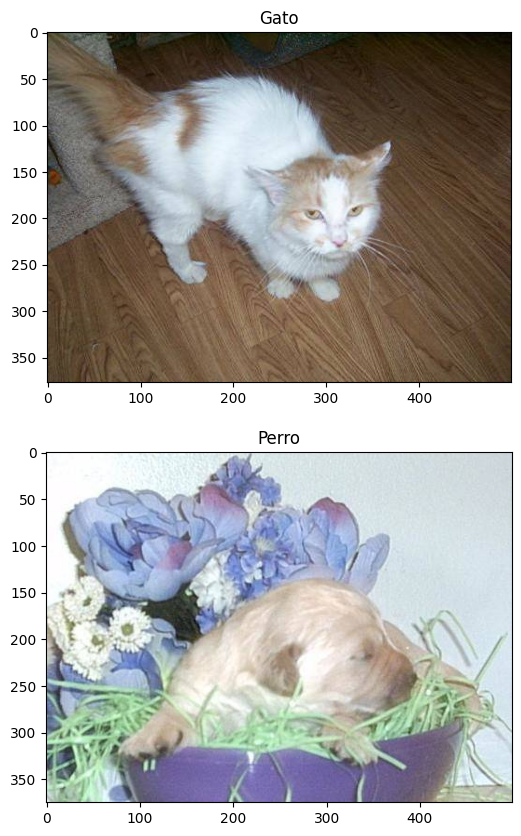

In [2]:
cat_image_name = random.choice(os.listdir("./dataset_perros_y_gatos/train/cats"))
cat_image = mpimg.imread(os.path.join("./dataset_perros_y_gatos/train/cats", cat_image_name))
dog_image_name = random.choice(os.listdir("./dataset_perros_y_gatos/train/dogs"))
dog_image = mpimg.imread(os.path.join("./dataset_perros_y_gatos/train/dogs", dog_image_name))

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].imshow(cat_image) 
axs[0].title.set_text('Gato') 

axs[1].imshow(dog_image)
axs[1].title.set_text('Perro')


## Utilizar los datos

Para consumir los datos con nuestro modelo vamos a utilizar objetos de la clase DataLoader. Tambien, para poder cargar imágenes propias utilizamos la clase [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder), a la cual le pasamos el directorio donde se encuentran las imágenes a partir del cual infiere las clases dentro del dataset. Para mas información respecto a este punto ver [aquí](https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder).

In [3]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/validation', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Ahora defino una red neuronal contemplando la opción de que, si existe una GPU, se mueva la red allí para optimizar el entrenamiento.

In [5]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                    [-1, 2]           1,026
Total params: 5,407,394
Trainable params: 5,407,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.63
Estima

In [6]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [7]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.0001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model, 
                noaug_optimizer, 
                noaug_loss, 
                noaug_metric,
                noaug_data,
                20,
                noaug_writer)

Epoch: 1/20 - Train loss 0.693704 - Train Accuracy 0.500000 - Valid Loss 0.691844 - Valid Accuracy 0.497070
Epoch: 2/20 - Train loss 0.690666 - Train Accuracy 0.529762 - Valid Loss 0.688045 - Valid Accuracy 0.588867
Epoch: 3/20 - Train loss 0.677428 - Train Accuracy 0.592262 - Valid Loss 0.667290 - Valid Accuracy 0.597656
Epoch: 4/20 - Train loss 0.648082 - Train Accuracy 0.627480 - Valid Loss 0.624423 - Valid Accuracy 0.650391
Epoch: 5/20 - Train loss 0.613120 - Train Accuracy 0.663194 - Valid Loss 0.605515 - Valid Accuracy 0.664062
Epoch: 6/20 - Train loss 0.601121 - Train Accuracy 0.683036 - Valid Loss 0.597077 - Valid Accuracy 0.674805
Epoch: 7/20 - Train loss 0.561070 - Train Accuracy 0.712798 - Valid Loss 0.585155 - Valid Accuracy 0.675781
Epoch: 8/20 - Train loss 0.547078 - Train Accuracy 0.729663 - Valid Loss 0.582541 - Valid Accuracy 0.668945
Epoch: 9/20 - Train loss 0.528910 - Train Accuracy 0.729663 - Valid Loss 0.558865 - Valid Accuracy 0.700195
Epoch: 10/20 - Train loss 0.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

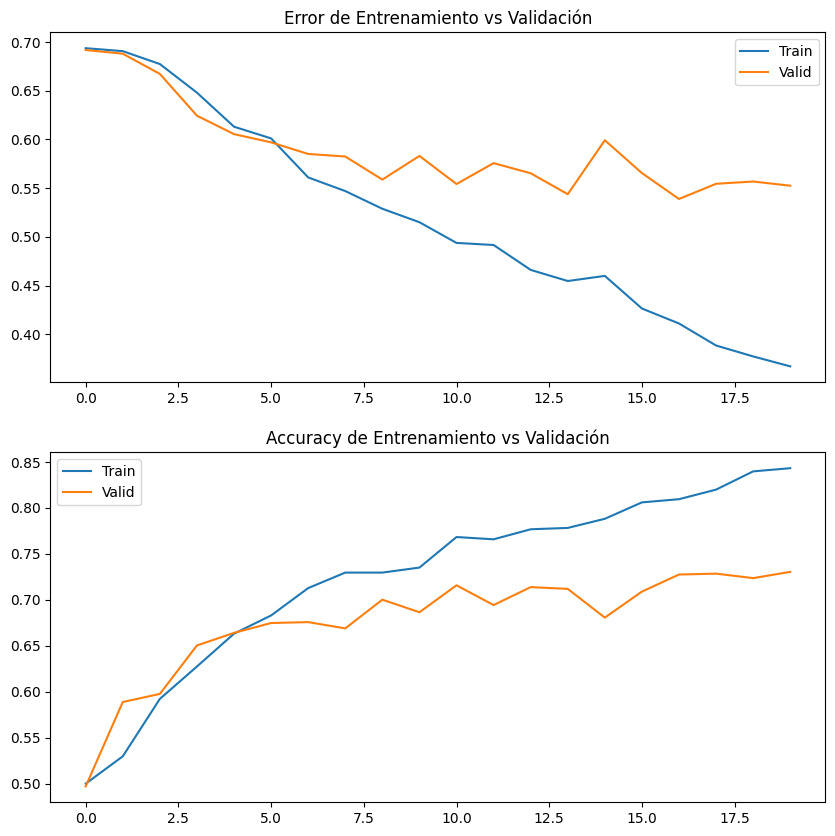

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Su puede observar una clara tendencia al sobreentrenamiento del modelo, el cual es debido a, entre otras cosas, la poca cantidad de datos de entrenamiento utilizados.

---
## Aplicar Data Augmentation

Para aplicar Data Augmentation sobre los datos vamos a utilizar la misma composición de transformaciones que ya veniamos utilizando. Allí podemos agregar una serie de funciones listadas [`aquí`](https://pytorch.org/vision/stable/transforms.html). Para ver ejemplos de dichas transformaciones ver [este](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) link.

Ademas de las transformaciones implementadas dentro del modulo `torchvision` de Pytorch, podemos optar por utilizar librerias externas para dicho proposito e integrar sus transformaciones en el pipeline de entrenamiento de Pytorch.

In [9]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/train', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/validation', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

Podemos visualizar el resultado de aplicar dichas transformaciones sobre las imágenes de nuestro dataset. Para ello debemos revertir la normalización aplicada por las transformaciones. Aquí el metodo [`permute`](https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute) nos permite reordenar las dimensiones del tensor de (3, 150, 150) a (150, 150, 3).

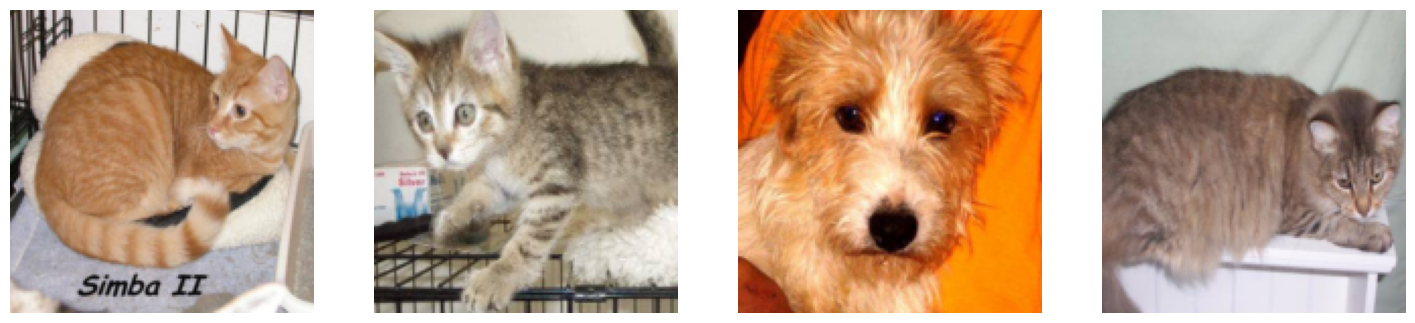

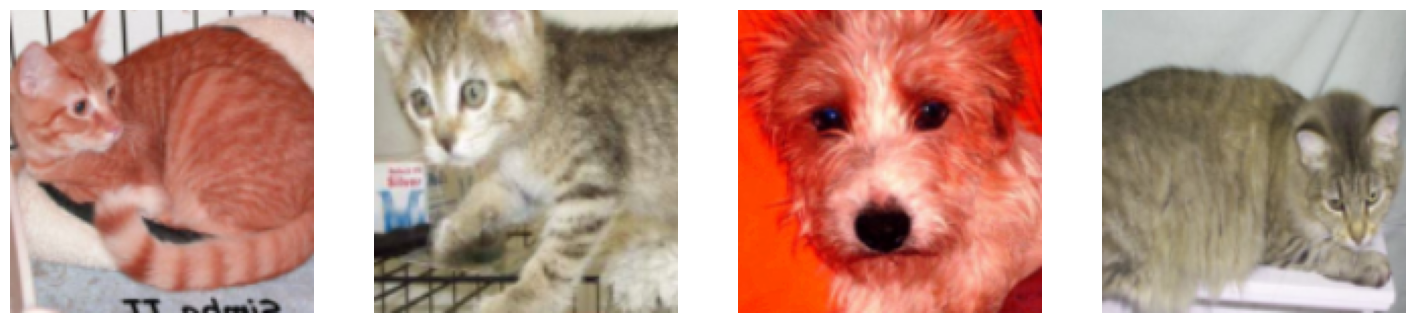

In [15]:
images_ids = np.random.randint(low=0, high=len(train_set), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Si ahora, repito el proceso de entrenamiento, utilizando la misma arquitectura de red neuronal del caso anterior, pero pasandole datos sobre los que realizo las perturbaciones antes definidas, mi entrenamiento deberia ser más estable aunque un poco mas lento.

In [11]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model, 
                aug_optimizer, 
                aug_loss, 
                aug_metric,
                aug_data,
                50,
                aug_writer)

Epoch: 1/50 - Train loss 0.692319 - Train Accuracy 0.514881 - Valid Loss 0.692654 - Valid Accuracy 0.505859
Epoch: 2/50 - Train loss 0.686225 - Train Accuracy 0.547619 - Valid Loss 0.691428 - Valid Accuracy 0.525391
Epoch: 3/50 - Train loss 0.678169 - Train Accuracy 0.574405 - Valid Loss 0.661854 - Valid Accuracy 0.598633
Epoch: 4/50 - Train loss 0.672537 - Train Accuracy 0.594246 - Valid Loss 0.657355 - Valid Accuracy 0.604492
Epoch: 5/50 - Train loss 0.652428 - Train Accuracy 0.632440 - Valid Loss 0.630517 - Valid Accuracy 0.644531
Epoch: 6/50 - Train loss 0.639633 - Train Accuracy 0.648810 - Valid Loss 0.617796 - Valid Accuracy 0.638672
Epoch: 7/50 - Train loss 0.638916 - Train Accuracy 0.637401 - Valid Loss 0.670816 - Valid Accuracy 0.583984
Epoch: 8/50 - Train loss 0.619904 - Train Accuracy 0.651290 - Valid Loss 0.625575 - Valid Accuracy 0.638672
Epoch: 9/50 - Train loss 0.617435 - Train Accuracy 0.672619 - Valid Loss 0.586222 - Valid Accuracy 0.689453
Epoch: 10/50 - Train loss 0.

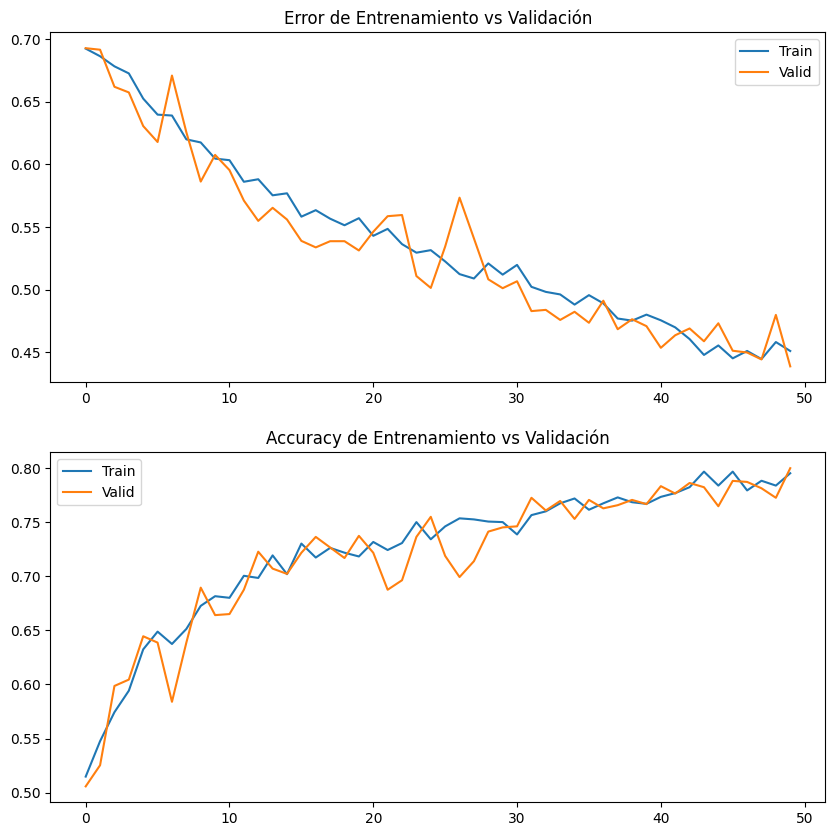

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

---
## TensorBoard

Otra forma de visualizar los resultados del entrenamiento de nuestra red es mediante la herramienta TensorBoard, la cual forma parte del framework de Tensorflow. Esta herramienta nos permite ver graficas interactivas de la evolución de las distintas metricas a lo largo de las epocas o las iteraciones de entrenamiento, así como también un grafo de las conexiones que componen nuestro modelo, entre otras cosas.

Tensorboard cuenta con una plataforma gratuita, llamada [Tensorboard.dev](https://tensorboard.dev/) donde podemos subir los resultados de nuestros experimentos, es decir, los archivos de Tensorboard generados por nuestro entrenamiento. De esta forma logramos un almacenamiento persistente de dichos resultados, que puede compartirse y compararse de forma mas sencilla a traves de un navegador desde cualquier lugar.

Para poder utilizar la plataforma debemos estar loggeados en una cuenta de google y acceder a este link: https://tensorboard.dev/experiments/. Luego, desde Colab, estando loggeados con la misma cuenta de google, el procedimiento es sencillo. Se debe ejecutar un comando como el siguiente, en donde se indica el path donde se encuentran los archivos con los experimentos, un nombre para almacenarlos y una descripcion.

In [16]:
!tensorboard dev upload --logdir ./data_aug \
  --name "Ejemplo 1era clase VPC2 CEIA - Data Augmentation" \
  --description "Estos experimentos muestran los resultados del entrenamiento de una arquitectura de red convolucional, sobre el dataset de perros y gatos, con y sin aplicacion de data augmentation." \
  --one_shot

TensorFlow installation not found - running with reduced feature set.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/UwrJPtkvQg69DIDWaABXgg/

[2023-03-02T16:38:06] Started scanning logdir.
[2023-03-02T16:38:10] Total uploaded: 280 scalars, 0 tensors, 4 binary objects (40.0 kB)
[2023-03-02T16:38:10] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/UwrJPtkvQg69DIDWaABXgg/
